# RL Exper

In [3]:
# !pip install stable-baselines3 --default-timeout=100

In [2]:
# train_uniswap_simple.py
# -----------------------
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ───── your environment ─────
from env_nikolai3 import UniswapV3LPGymEnv
from config.env_config import Config

# ───── RL + utils ─────
import gymnasium as gym
from gymnasium.wrappers import TimeLimit, RecordEpisodeStatistics, FlattenObservation
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

# ───── hyper‑params you might tweak ─────
TOTAL_TIMESTEPS      = 1_000     # training steps
MAX_EPISODE_MINUTES  = 1_000     # one‑day cap

# ╭────────────────────────── helpers ───────────────────────────╮
def make_env():
    cfg = Config()
    env = UniswapV3LPGymEnv(cfg, feat_num=19)

    env = TimeLimit(env, max_episode_steps=MAX_EPISODE_MINUTES)
    env = RecordEpisodeStatistics(env)
    env = FlattenObservation(env)

    logs_dir = Path("logs");  logs_dir.mkdir(exist_ok=True)
    env = Monitor(env, str(logs_dir), allow_early_resets=True)   # ← str() fix
    return env


def plot_learning_curve(monitor_csv: Path, title: str = "Learning curve") -> None:
    df = pd.read_csv(monitor_csv, comment="#")
    df["rolling_return"] = df["r"].rolling(window=20).mean()
    plt.figure(figsize=(8, 4))
    plt.plot(df["l"], df["rolling_return"])
    plt.xlabel("Episode"); plt.ylabel("Reward (20‑ep MA)")
    plt.title(title); plt.grid(True)
    plt.tight_layout(); plt.show()


# ╭────────────────────────── training ──────────────────────────╮
def main():
    # 1⃣  make vectorised env
    env = DummyVecEnv([make_env])

    # 2⃣  define agent
    model = PPO(
        "MlpPolicy",
        env,
        # n_steps       = 2048,
        n_steps       = 1024,
        batch_size    = 256,
        gae_lambda    = 0.95,
        gamma         = 0.999,
        learning_rate = 3e-4,
        clip_range    = 0.2,
        vf_coef       = 0.5,
        ent_coef      = 0.0,
        verbose       = 1,
        # tensorboard_log="tensorboard",
        device="auto",
    )

    # 3⃣  learn
    model.learn(total_timesteps=TOTAL_TIMESTEPS, progress_bar=False)

    # 4⃣  save & evaluate
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M")
    model_path = Path("models"); model_path.mkdir(exist_ok=True)
    fname = model_path / f"ppo_uniswap_{ts}"
    model.save(fname)
    print(f"\n✔️  Saved model to {fname}.zip")

    mean_r, std_r = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Evaluation over 10 eps → mean ± std reward: {mean_r:.2f} ± {std_r:.2f}")

    # 5⃣  plot learning curve
    monitors = sorted(Path("logs").glob("*.monitor.csv"))
    if monitors:
        plot_learning_curve(monitors[-1], title="PPO on Uniswap‑V3 LP env")
    else:
        print("No monitor file found ‑ nothing to plot.")


if __name__ == "__main__":  
    main()

Using cpu device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -3.37e+03 |
| time/              |           |
|    fps             | 19        |
|    iterations      | 1         |
|    time_elapsed    | 51        |
|    total_timesteps | 1024      |
----------------------------------

✔️  Saved model to models/ppo_uniswap_20250627_1500.zip
Evaluation over 10 eps → mean ± std reward: 0.00 ± 0.00
No monitor file found ‑ nothing to plot.


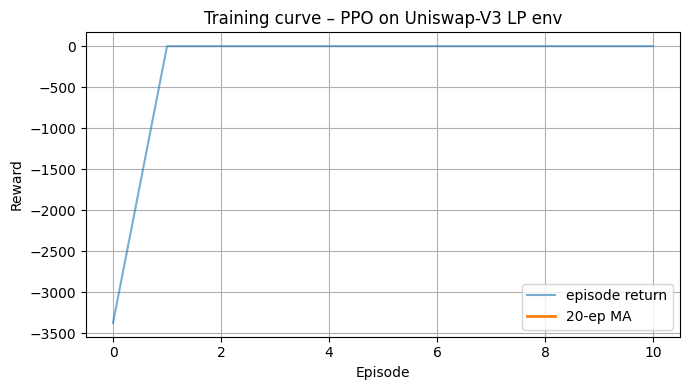

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

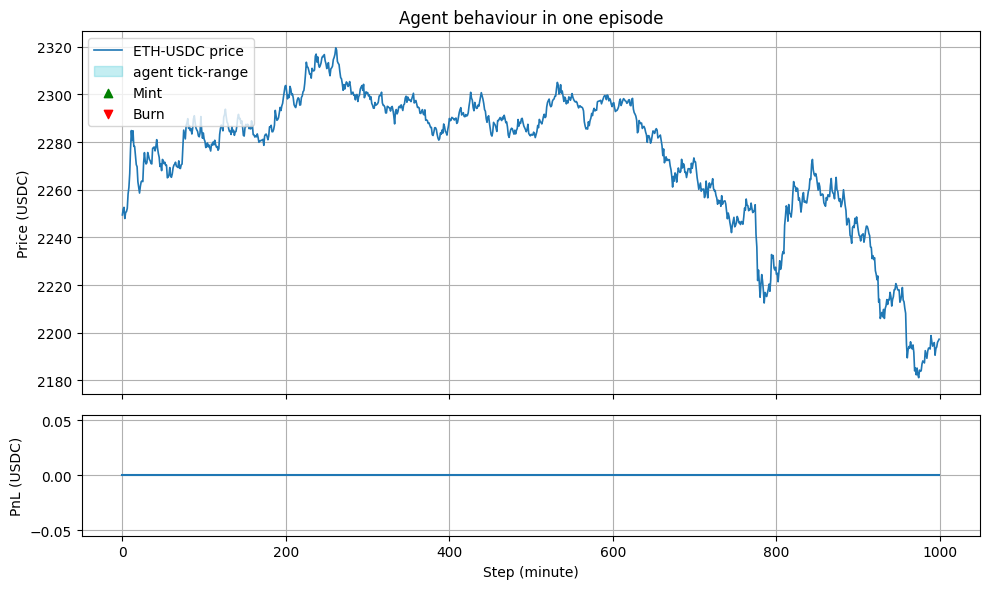

Raw actions from policy (shape (1000, 2)):
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import torch


def tick_to_price(tick: int) -> float:
    sqrtp = 1.0001 ** (tick / 2)
    return sqrtp ** 2


def plot_learning_curve(log_dir: Path):
    """Plot episodic returns + 20-episode moving average."""
    mon_csv = sorted(log_dir.glob("monitor.csv"))[-1]
    df = pd.read_csv(mon_csv, comment="#")
    ep_returns = df["r"].to_numpy()
    ma = pd.Series(ep_returns).rolling(20).mean()

    plt.figure(figsize=(7, 4))
    plt.plot(ep_returns, label="episode return", alpha=0.6)
    plt.plot(ma, label="20-ep MA", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training curve – PPO on Uniswap-V3 LP env")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def run_episode_and_plot(model, env):
    """Roll one episode, record price / actions, then plot & print actions."""
    obs, _ = env.reset()

    prices, plow, phigh = [], [], []
    mints_x, mints_y, burns_x, burns_y = [], [], [], []
    cum_pnl = []
    actions_out = []

    done = False
    step = 0
    while not done and step < env.EPISODE_LEN:
        ts = env.decision_grid[env.idx]
        p = env._eth_price(ts)

        # policy action
        action, _ = model.predict(obs, deterministic=True)
        actions_out.append(action.copy())

        pre_active = env.active           # ← state BEFORE step
        obs, reward, done, trunc, info = env.step(action)
        post_active = env.active          # ← state AFTER step

        prices.append(p)
        if post_active:
            plow.append(tick_to_price(env.tick_l))
            phigh.append(tick_to_price(env.tick_u))
        else:
            plow.append(np.nan)
            phigh.append(np.nan)

        # Mint event: inactive → active
        if (pre_active is False) and (post_active is True):
            mints_x.append(step)
            mints_y.append(p)
        # Burn event: active → inactive
        elif (pre_active is True) and (post_active is False):
            burns_x.append(step)
            burns_y.append(p)

        cum_pnl.append(env.cumulative_pnl)
        step += 1

    t = np.arange(len(prices))

    print(plow)
    print(phigh)

    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                            gridspec_kw={"height_ratios": [3, 1]})

    # (a) price + agent band
    axs[0].plot(t, prices, label="ETH-USDC price", linewidth=1.2)
    axs[0].fill_between(t, plow, phigh, color="tab:cyan", alpha=0.25,
                        label="agent tick-range")
    axs[0].scatter(mints_x, mints_y, marker="^", color="green", label="Mint")
    axs[0].scatter(burns_x, burns_y, marker="v", color="red", label="Burn")
    axs[0].set_ylabel("Price (USDC)")
    axs[0].set_title("Agent behaviour in one episode")
    axs[0].legend(loc="upper left")
    axs[0].grid(True)

    # (b) cumulative PnL
    axs[1].plot(t, cum_pnl, label="cumulative PnL")
    axs[1].set_ylabel("PnL (USDC)")
    axs[1].set_xlabel("Step (minute)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    # show the raw 2-D actions
    actions_arr = np.array(actions_out)
    print(f"Raw actions from policy (shape {actions_arr.shape}):")
    np.set_printoptions(precision=3, suppress=True)
    print(actions_arr)


if __name__ == "__main__":
    LOG_DIR = Path("logs")
    MODEL_DIR = Path("models")

    plot_learning_curve(LOG_DIR)

    latest_model = sorted(MODEL_DIR.glob("ppo_uniswap_*.zip"))[-1]
    from stable_baselines3 import PPO
    from env_nikolai3 import UniswapV3LPGymEnv
    from config.env_config import Config

    env = UniswapV3LPGymEnv(Config(), feat_num=19)
    env.EPISODE_LEN = 1000  # IMPORTANT

    model = PPO.load(latest_model, env=env)
    run_episode_and_plot(model, env)

# Sanity Checks

CEX shape & span : (17396, 1) 2025-03-04 15:38:00 → 2025-03-16 17:51:00
DEX shape & span : (109025, 1) 2025-03-04 15:37:11 → 2025-03-16 17:50:59


simulating episode:   0%|          | 0/1000 [00:00<?, ?step/s]

simulating episode:   0%|          | 0/1000 [00:00<?, ?step/s]

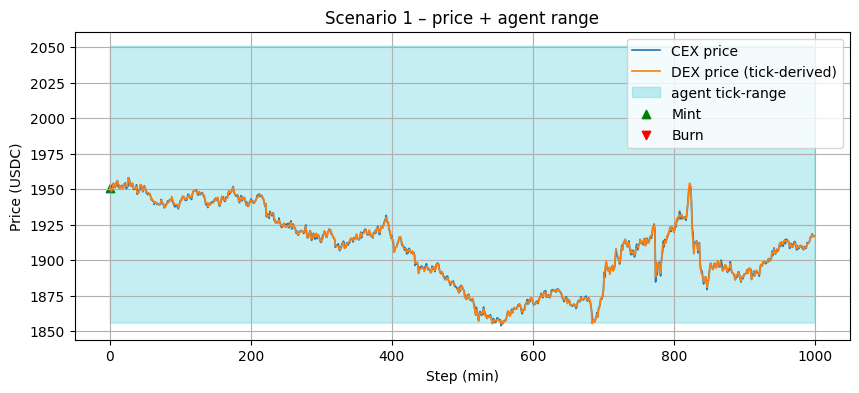

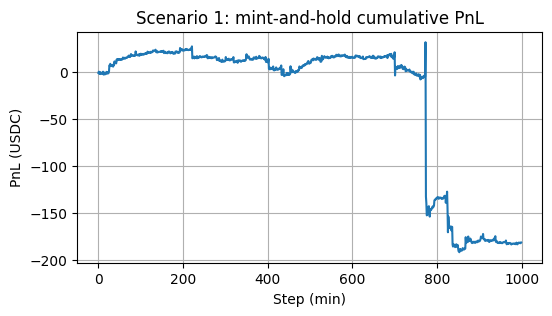

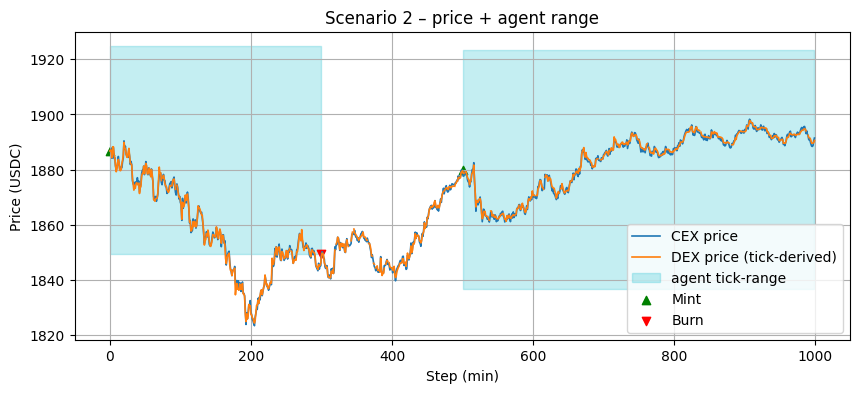

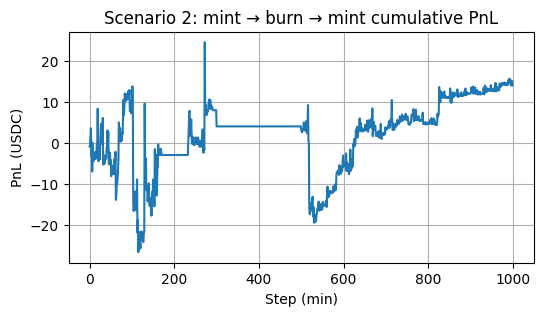

In [1]:
from tqdm.auto import tqdm     
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from env_nikolai3 import UniswapV3LPGymEnv
from config.env_config import Config


# ------------------------------- helpers ---------------------------------
def tick_to_price(tick: int) -> float:
    return 1e12 / (1.0001 ** (tick / 2)) ** 2


def get_dex_price(env, ts):
    """Convert pool tick at *ts* into a USDC-per-ETH price (forward-fill)."""
    if ts in env.lp_span.index:
        tick = env.lp_span.loc[ts, "tick"]
        if isinstance(tick, pd.Series):
            tick = tick.mean()
    else:                                # forward-fill
        pos = env.lp_span.index.searchsorted(ts, side="right") - 1
        tick = env.lp_span.iloc[pos]["tick"]
        if isinstance(tick, pd.Series):
            tick = tick.mean()
    return tick_to_price(float(tick))


### <<< NEW ----------------------------------------------------------------
def run_scenario_with_band(env, action_fn, show_progress: bool = True):
    """
    Same as run_scenario, but also records:
      • lower/upper price bounds of the agent's range
      • mint & burn timestamps for plotting markers
    """
    obs, _ = env.reset()
    cex_px, dex_px, pnl = [], [], []
    plow, phigh = [], []
    mints_x, mints_y, burns_x, burns_y = [], [], [], []

    done, step = False, 0
    iterator = tqdm(total=env.EPISODE_LEN, desc="simulating episode",
                    disable=not show_progress, unit="step")

    while not done:
        ts = env.decision_grid[env.idx]
        cex_px.append(env._eth_price(ts))
        dex_px.append(get_dex_price(env, ts))

        pre_active = env.active
        action = action_fn(step)
        obs, reward, done, *_ = env.step(action)
        post_active = env.active
        pnl.append(env.cumulative_pnl)

        # range boundaries (only when active)
        if post_active:
            plow.append(tick_to_price(env.tick_l))
            phigh.append(tick_to_price(env.tick_u))
        else:
            plow.append(np.nan)
            phigh.append(np.nan)

        # mint / burn markers
        if (pre_active is False) and (post_active is True):
            mints_x.append(step)
            mints_y.append(cex_px[-1])
        elif (pre_active is True) and (post_active is False):
            burns_x.append(step)
            burns_y.append(cex_px[-1])

        step += 1
        iterator.update(1)

    iterator.close()
    t_arr = np.arange(step)
    return (t_arr, np.array(cex_px), np.array(dex_px), np.array(pnl),
            np.array(plow), np.array(phigh),
            np.array(mints_x), np.array(mints_y),
            np.array(burns_x), np.array(burns_y))
# -------------------------------------------------------------------------


def run_scenario(env, action_fn, show_progress: bool = True):
    """(kept for backward compatibility)"""
    (t, cex_px, dex_px, pnl, *_extras) = run_scenario_with_band(
        env, action_fn, show_progress)
    return t, cex_px, dex_px, pnl



# ----------------------- build environment & print shapes ----------------
env_cfg = Config()
base_env = UniswapV3LPGymEnv(env_cfg, feat_num=12)
base_env.EPISODE_LEN = 1_000

print("CEX shape & span :", base_env.eth_px.shape, 
      base_env.eth_px.index.min(), "→", base_env.eth_px.index.max())
print("DEX shape & span :", base_env.lp_span.shape, 
      base_env.lp_span.index.min(), "→", base_env.lp_span.index.max())

# ----------------------- Scenario 1: mint-and-hold -----------------------
def s1_action(step):
    """Mint at t=0 with width=10 and keep the position live."""
    return np.array([1.0, np.random.randint(100, 200)], dtype=np.float32)  # engage = 1, width = 10

(t1, cex1, dex1, pnl1,
 plow1, phigh1,
 mints1_x, mints1_y,
 burns1_x, burns1_y) = run_scenario_with_band(base_env, s1_action)

# ----------------------- Scenario 2: mint, burn, mint --------------------
env2 = UniswapV3LPGymEnv(env_cfg, feat_num=12)
env2.EPISODE_LEN = 1_000

def s2_action(step):
    """Mint (0-299), burn (300-499), mint again (500-999)."""
    if step in (0, 500):
        return np.array([1.0, np.random.randint(20, 50)], dtype=np.float32)  # (re)mint
    if 0 < step < 300 or step >= 500:
        return np.array([1.0, np.random.randint(20, 50)], dtype=np.float32)  # keep active
    return np.array([0.0, 0.0], dtype=np.float32)       # burn/idle

(t2, cex2, dex2, pnl2,
 plow2, phigh2,
 mints2_x, mints2_y,
 burns2_x, burns2_y) = run_scenario_with_band(env2, s2_action)


# ----------------------------- PLOTS -------------------------------------
# (A) price comparison + agent band – Scenario 1
plt.figure(figsize=(10,4))
plt.plot(t1, cex1, label="CEX price", linewidth=1.2)
plt.plot(t1, dex1, label="DEX price (tick-derived)", linewidth=1.2)
plt.fill_between(t1, plow1, phigh1, color="tab:cyan", alpha=0.25,
                 label="agent tick-range")
plt.scatter(mints1_x, mints1_y, marker="^", color="green", label="Mint")
plt.scatter(burns1_x, burns1_y, marker="v", color="red", label="Burn")
plt.xlabel("Step (min)")
plt.ylabel("Price (USDC)")
plt.title("Scenario 1 – price + agent range")
plt.legend()
plt.grid(True)

# (B) Scenario 1 cumulative PnL
plt.figure(figsize=(6,3))
plt.plot(t1, pnl1)
plt.xlabel("Step (min)")
plt.ylabel("PnL (USDC)")
plt.title("Scenario 1: mint-and-hold cumulative PnL")
plt.grid(True)

# (C) price comparison + agent band – Scenario 2
plt.figure(figsize=(10,4))
plt.plot(t2, cex2, label="CEX price", linewidth=1.2)
plt.plot(t2, dex2, label="DEX price (tick-derived)", linewidth=1.2)
plt.fill_between(t2, plow2, phigh2, color="tab:cyan", alpha=0.25,
                 label="agent tick-range")
plt.scatter(mints2_x, mints2_y, marker="^", color="green", label="Mint")
plt.scatter(burns2_x, burns2_y, marker="v", color="red", label="Burn")
plt.xlabel("Step (min)")
plt.ylabel("Price (USDC)")
plt.title("Scenario 2 – price + agent range")
plt.legend()
plt.grid(True)

# (D) Scenario 2 cumulative PnL
plt.figure(figsize=(6,3))
plt.plot(t2, pnl2)
plt.xlabel("Step (min)")
plt.ylabel("PnL (USDC)")
plt.title("Scenario 2: mint → burn → mint cumulative PnL")
plt.grid(True)

plt.show()

# Price Plotting CEX vs DEX

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from env_nikolai3 import UniswapV3LPGymEnv
from config.env_config import Config

env_cfg = Config()
env = UniswapV3LPGymEnv(env_cfg, feat_num=12)
env.EPISODE_LEN = 1_000

# ------------------------------------------------------------------
# helper: convert pool tick → price (USDC per 1 ETH)
def tick_to_price(tick: int | float) -> float:
    return 1e12 / (1.0001 ** tick)        # √P → P

# ------------------------------------------------------------------
# 1) build a single DataFrame with CEX & DEX prices on a 1-minute grid
df = pd.DataFrame(index=env.decision_grid)

# CEX – forward-fill the Binance/Coinbase “open” column
df["cex_price"] = (
    env.eth_px.reindex(df.index, method="ffill")["open"]
)

# DEX – convert the pool tick into a price, forward-filled
dex_tick_series = (
    env.lp_span["tick"]
        .groupby("timestamp")         # collapse duplicate ts (safety)
        .last()                       # or .mean()
        .reindex(df.index, method="ffill")
)
df["dex_price"] = tick_to_price(dex_tick_series)

# ------------------------------------------------------------------
# 2) plot
plt.figure(figsize=(9, 4))
plt.plot(df.index, df["cex_price"], label="CEX price", linewidth=1.2)
plt.plot(df.index, df["dex_price"], label="DEX price (Uniswap V3)", linewidth=1.2)
plt.title("CEX vs DEX price (USDC per ETH)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()